# Image Processing with Python 

## Installing Anaconda, a Python distribution

## Handling images in Python

### Reading an input image

* First we import the necessary packages.

In [1]:
from skimage.io import imread

import matplotlib.pyplot as plt

* Using the imported function `imread`, let's read `image1.bmp` from the disk.

In [2]:
image = imread('image1.bmp')

* Images are represented in `scikit-image` as arrays. To check its shape and number of dimensions, we can use `image.shape` and `image.ndim`.

In [3]:
image.shape

(574, 768)

In [4]:
image.ndim

2

* To show an image, we use `matplotlib.pyplot.imshow()`. Since we imported as `matplotlib.pyplot` as `plt`, we use only `plt.imshow()`.

In [5]:
plt.imshow(image)

* Then, to show the window containing the image, we use `plt.show()`. 

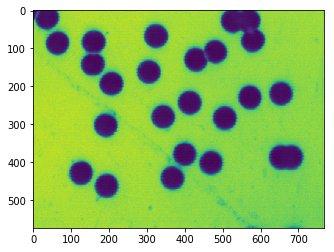

In [6]:
plt.show()

* This last step is not necessary when using the "Jupyter magic" `%matplotlib inline` before:

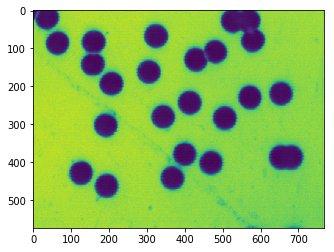

In [7]:
%matplotlib inline

plt.imshow(image)

* We can create a larger figure using the function `plt.figure()` for seeing the results easier. To do that, we use the argument `figsize`. 

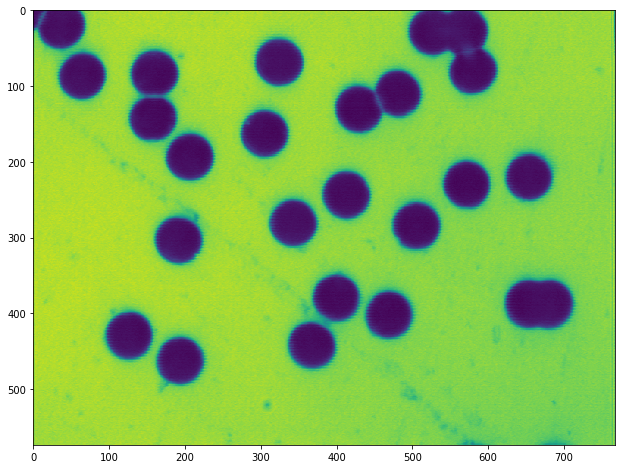

In [9]:
plt.figure(figsize=(12, 8))
plt.imshow(image)

### Using different colormaps

* Matplotlib has a list with several colormaps, the default being `viridis`. Let's try the examples `gray`, `magma`, and `nipy_spectral`.

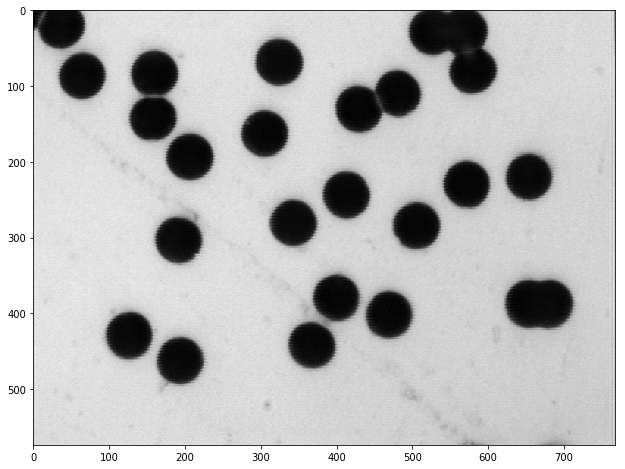

In [10]:
plt.figure(figsize=(12, 8))
plt.imshow(image, cmap='gray')

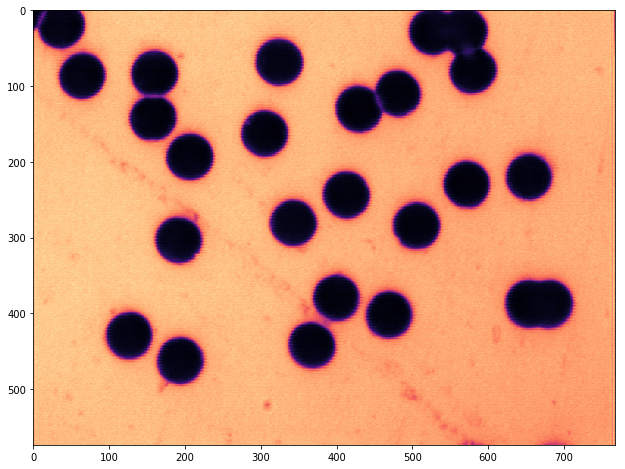

In [11]:
plt.figure(figsize=(12, 8))
plt.imshow(image, cmap='magma')

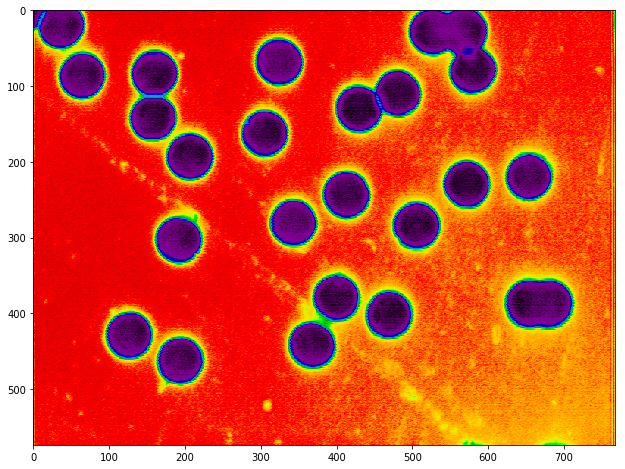

In [12]:
plt.figure(figsize=(12, 8))
plt.imshow(image, cmap='nipy_spectral')

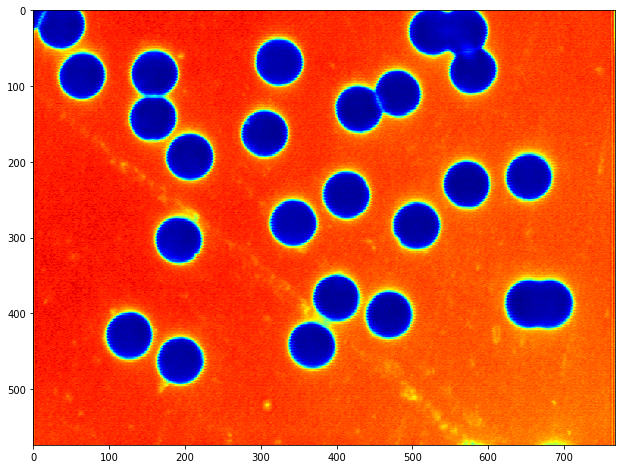

In [13]:
plt.figure(figsize=(12, 8))
plt.imshow(image, cmap='jet')

* Take a look at the full list at <https://matplotlib.org/examples/color/colormaps_reference.html>.

## Pre-processing and enhancing images

* Let's filter the input image using the Gaussian filter. 

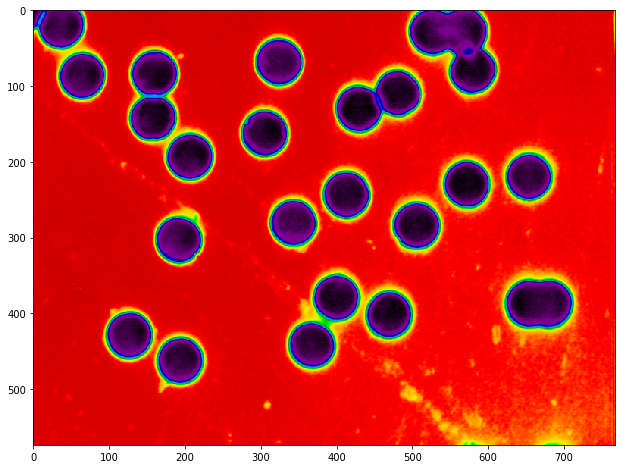

In [16]:
from skimage.filters import gaussian

gauss_img1 = gaussian(image)

plt.figure(figsize=(12, 8))
plt.imshow(gauss_img1, cmap='nipy_spectral')

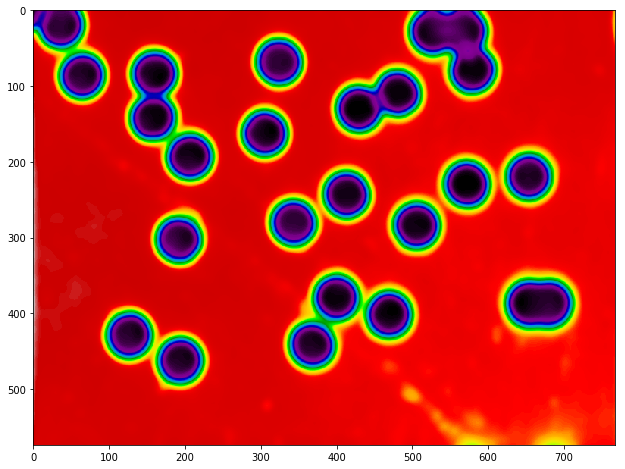

In [18]:
from skimage.filters import gaussian

gauss_img1 = gaussian(image, sigma=5)

plt.figure(figsize=(12, 8))
plt.imshow(gauss_img1, cmap='nipy_spectral')

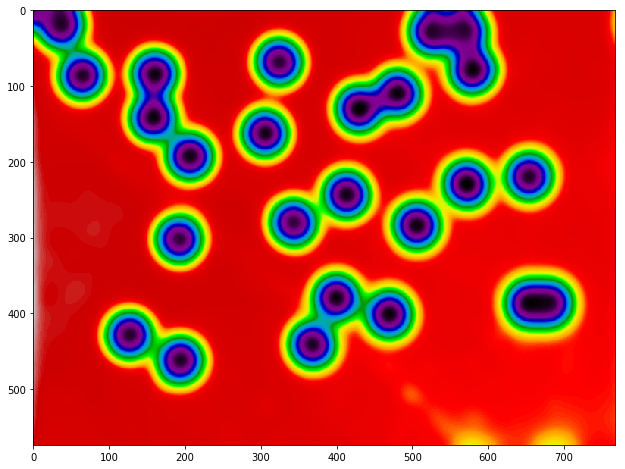

In [20]:
from skimage.filters import gaussian

gauss_img1 = gaussian(image, sigma=10)

plt.figure(figsize=(12, 8))
plt.imshow(gauss_img1, cmap='nipy_spectral')

## Image binarization and segmentation

* Let's binarize the input image using different algorithms: Otsu, Mean and Triangle.

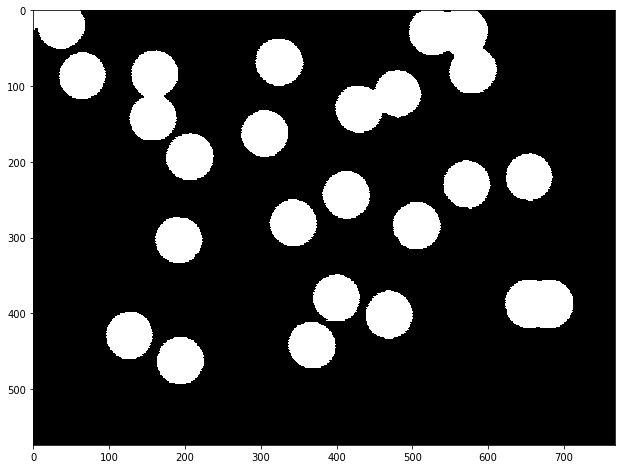

In [21]:
from skimage.filters import threshold_otsu, threshold_mean, threshold_triangle

otsu_thr = threshold_otsu(image)
otsu_bin = otsu_thr > image

plt.figure(figsize=(12, 8))
plt.imshow(otsu_bin, cmap='gray')

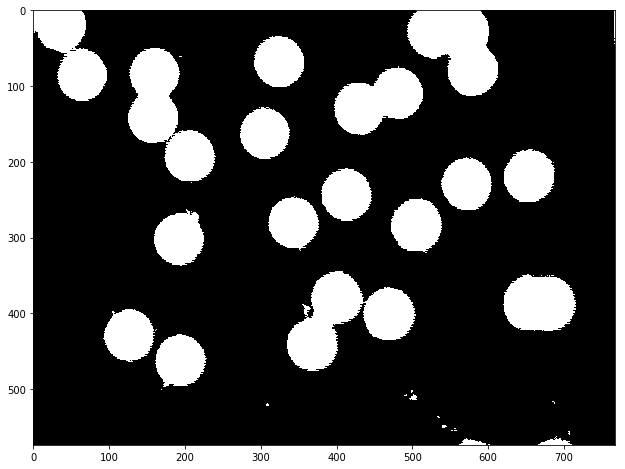

In [22]:
mean_thr = threshold_mean(image)
mean_bin = mean_thr > image

plt.figure(figsize=(12, 8))
plt.imshow(mean_bin, cmap='gray')

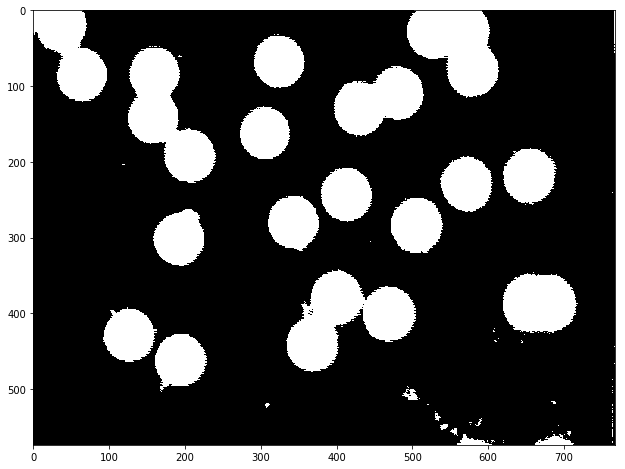

In [23]:
tri_thr = threshold_triangle(image)
tri_bin = tri_thr > image

plt.figure(figsize=(12, 8))
plt.imshow(tri_bin, cmap='gray')

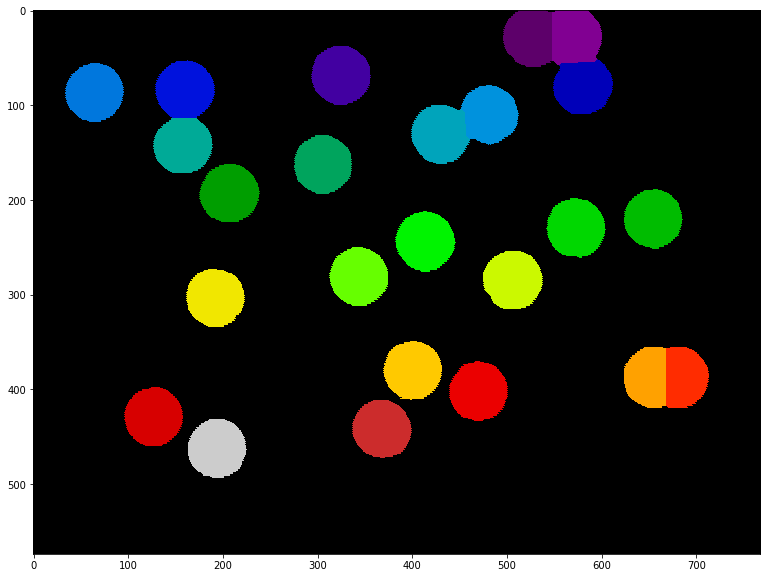

In [25]:
from skimage.feature import peak_local_max
from skimage.measure import label
from skimage.morphology import watershed
from scipy.ndimage import distance_transform_edt

import numpy as np

dist = distance_transform_edt(otsu_bin)
local_max = peak_local_max(dist,
                           indices=False,
                           footprint=np.ones((20, 20)),
                           labels=otsu_bin)
markers = label(local_max)
labels = watershed(-dist, markers, mask=otsu_bin)

plt.figure(figsize=(15, 10))
plt.imshow(labels, cmap='nipy_spectral')

## Region properties and labels

* A full list of attributes available by `regionprops` can be found at: <http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops>

# A case study

* Let's perform our studies on a different case. First we read the input image using `imread`. The argument `as_grey=True` asks `imread` to read the image as a gray (two-dimensional) image.

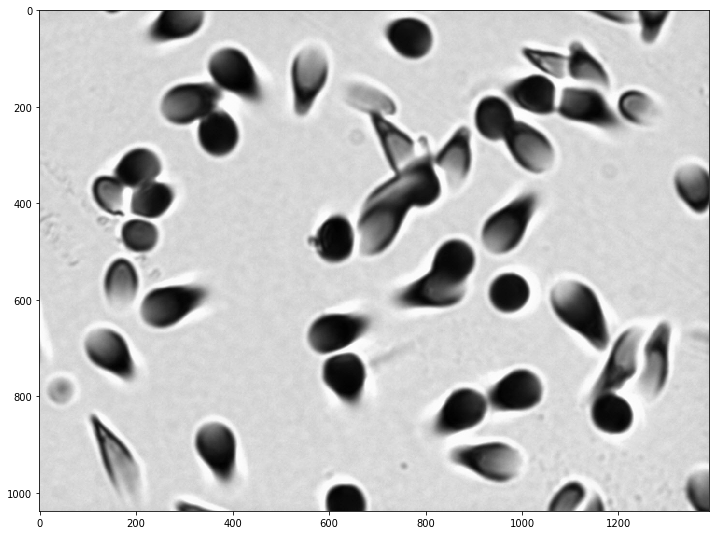

In [26]:
image = imread('harder_case.jpg', as_grey=True)

plt.figure(figsize=(12, 10))
plt.imshow(image, cmap='gray')

* Now we binarize the input image; let's try another algorithm, the ISODATA. It is also available at `skimage.filters`, in the function `threshold_isodata`. It works in the same way the previous thresholds do; it will return a threshold number, which we will use to generate our binary image. 

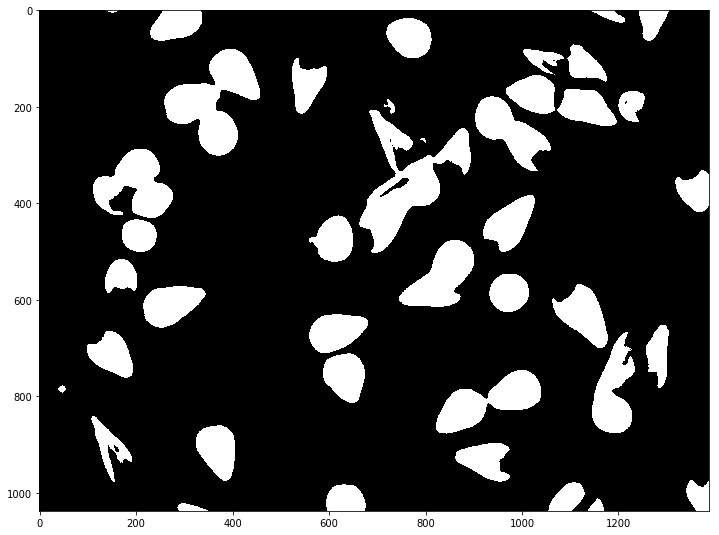

In [27]:
from skimage.filters import threshold_isodata

thresh_iso = threshold_isodata(image)
img_bin = image < thresh_iso

plt.figure(figsize=(12, 10))
plt.imshow(img_bin, cmap='gray')

* The binary image contains some small elements; let's remove them using `remove_small_objects`.

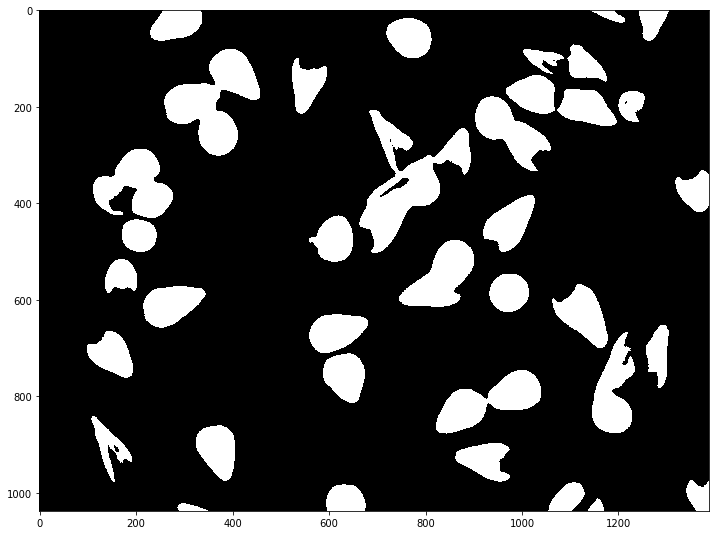

In [28]:
from skimage.morphology import remove_small_objects

img_clean = remove_small_objects(img_bin, min_size=300)

plt.figure(figsize=(12, 10))
plt.imshow(img_clean, cmap='gray')

* Some regions have holes within them; this could become an issue when using the watershed algorithm. Now we use `binary_fill_holes` from `scipy.ndimage` to fill these regions. This will be our main binary image.

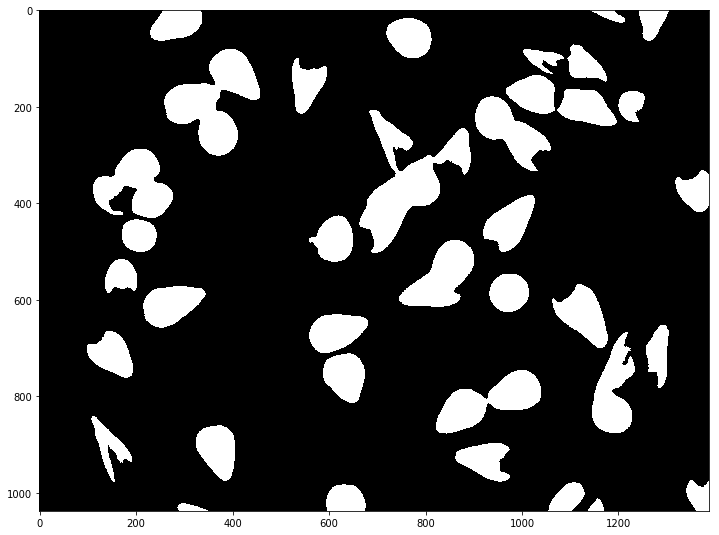

In [29]:
from scipy.ndimage import binary_fill_holes

img_fill = binary_fill_holes(img_clean)

plt.figure(figsize=(12, 10))
plt.imshow(img_fill, cmap='gray')

* Now we use `distance_transform_edt` to return the distances.

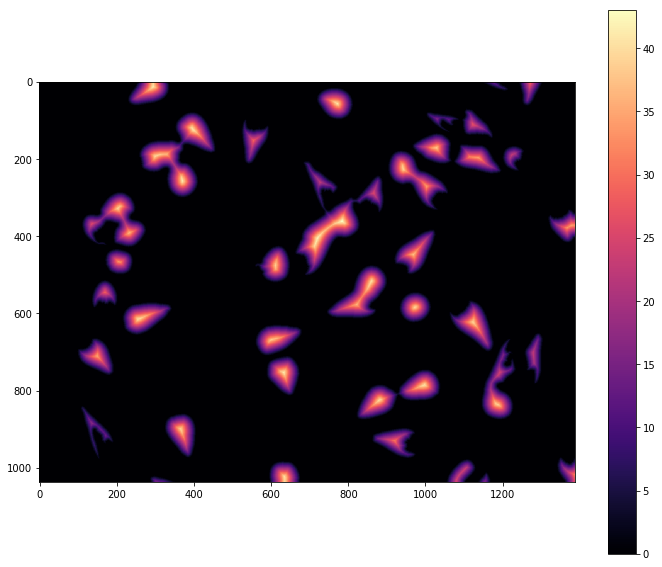

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import distance_transform_edt

distance = distance_transform_edt(img_fill)

plt.subplots(figsize=(12, 10))
plt.imshow(distance, cmap='magma')
plt.colorbar()

* Then we use `peak_local_max` to generate markers for the watershed transform. Make some effort to see the local max points :)

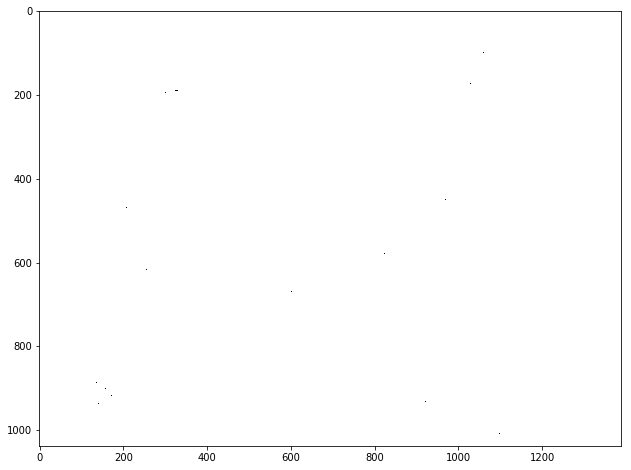

In [31]:
from skimage.feature import peak_local_max

import numpy as np

local_max = peak_local_max(distance,
                           indices=False,
                           footprint=np.ones((15, 15)),
                           labels=img_fill)

plt.figure(figsize=(12, 8))
plt.imshow(local_max, cmap='binary')

* Here we apply the watershed transform, which returns labels for each separated region.

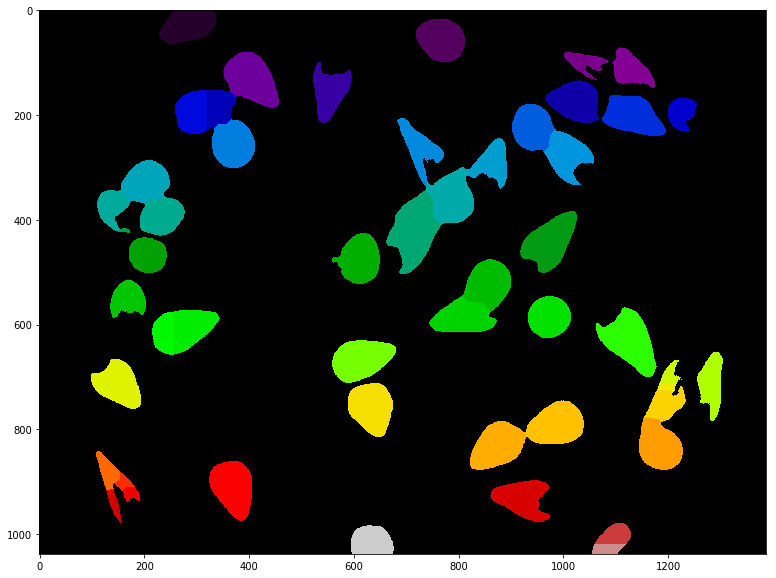

In [33]:
from skimage.measure import label
from skimage.morphology import watershed

markers = label(local_max)
labels = watershed(-distance, markers, mask=img_fill)

plt.figure(figsize=(15, 10))
plt.imshow(labels, cmap='nipy_spectral')

* Now, we use eccentricity to obtain "rounder" tracks within the image.

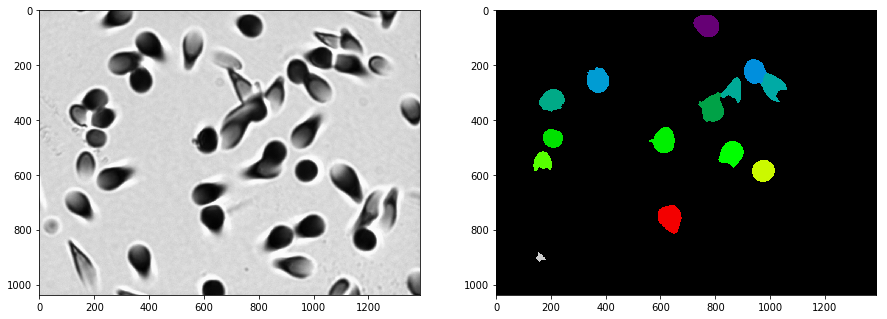

In [34]:
from skimage.measure import regionprops

properties = regionprops(labels, intensity_image=image)

tolerance_eccen = 0.6

for prop in properties:
    if prop.eccentricity > tolerance_eccen:
        labels[labels == prop.label] = 0

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(labels, cmap='nipy_spectral')

* Let's get the areas of the tracks left.

In [36]:
trk_areas = []

new_props = regionprops(labels, intensity_image=image)

for prop in new_props:
    trk_areas.append(prop.area)

trk_areas = np.asarray(trk_areas)
print(trk_areas)

[6056 5594 5990 5590 3943 5700 6835 3985 6074 6257 3525 5178 6690  649]


* Let's finish with their histogram and a fit.

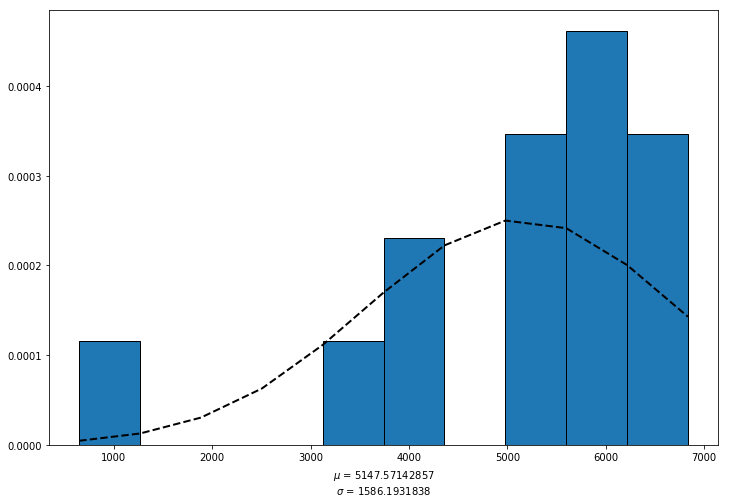

In [38]:
from scipy.stats import norm
import matplotlib.mlab as mlab

fig, ax = plt.subplots(figsize=(12, 8))

(mu, sigma) = norm.fit(trk_areas)
n, bins, patches = ax.hist(trk_areas, normed=True, edgecolor='k')
fit = mlab.normpdf(bins, mu, sigma)
line = ax.plot(bins, fit, 'k--', linewidth=2)
ax.set_xlabel('$\mu$ = ' + str(trk_areas.mean()) + '\n' + '$\sigma$ = ' + str(trk_areas.std()))

# Notes